In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
column_names = [
    "Mcg", "Gvh", "Alm", "Mit", "Erl", "Pox", "Vac", "Nuc", "Class"
]

# Чтение файла, пропуская строки, начинающиеся с '@'
df_yeast = pd.read_csv(
    "yeast1.dat",
    comment='@',          # Игнорируем строки, начинающиеся с '@'
    header=None,           # Нет заголовка в файле, заголовки задаем сами
    names=column_names,    # Имена колонок
    skip_blank_lines=True  # Пропускаем пустые строки
)

# Выводим DataFrame для проверки
df_yeast

,Mcg,Gvh,Alm,Mit,Erl,Pox,Vac,Nuc,Class
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,negative
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,negative
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,negative
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,positive
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,negative
...,...,...,...,...,...,...,...,...,...
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,negative
1480,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,positive
1481,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,negative
1482,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,positive


In [3]:
df_yeast["Class"].value_counts()


 negative    1055
 positive     429
Name: Class, dtype: int64

In [4]:
df_yeast["Class"].unique()

array([' negative', ' positive'], dtype=object)

In [5]:
df_yeast["Class"] = df_yeast["Class"].map({" negative": 0, " positive": 1})

df_yeast

,Mcg,Gvh,Alm,Mit,Erl,Pox,Vac,Nuc,Class
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,0
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,0
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,0
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,1
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,0
...,...,...,...,...,...,...,...,...,...
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,0
1480,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,1
1481,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,0
1482,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,1


In [6]:
X = df_yeast.drop(columns="Class")
y = df_yeast["Class"]

Разделим дата фрейм на обучающую, тестовую  выборки в 
соотношении 7 к 3 с применением стратификации.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
y_test

591     0
672     0
881     1
654     0
1423    0
       ..
373     1
1327    0
629     0
1394    0
1213    0
Name: Class, Length: 446, dtype: int64

Построим дерево решений

Параметры модели: {'ccp_alpha': 0.01, 'criterion': 'entropy'}
ROC-AUC = 0.746727820211516


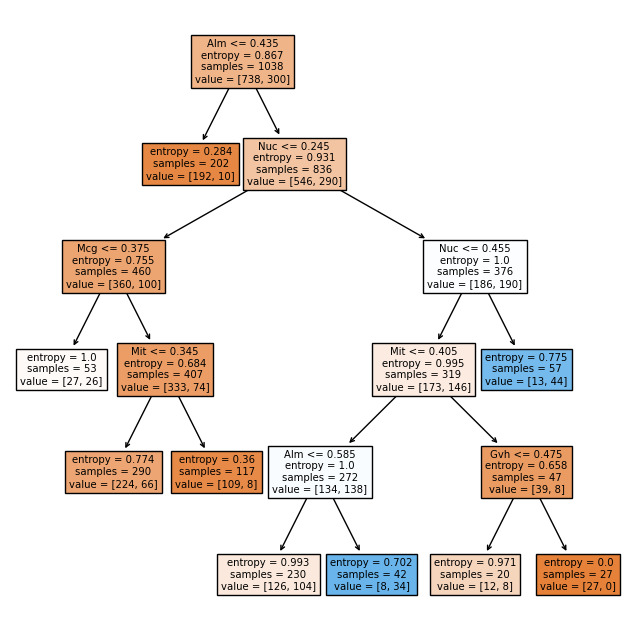

In [8]:
params = {"criterion" : ["entropy", "gini"], \
"ccp_alpha" : [0.005,0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.2, 0.8]}

decision_tree = DecisionTreeClassifier()

grid_search_dt = GridSearchCV(decision_tree, param_grid=params, scoring="roc_auc", cv=4)
grid_search_dt.fit(X_train, y_train)

best_decision_tree = grid_search_dt.best_estimator_

print("Параметры модели:", grid_search_dt.best_params_)
print("ROC-AUC =", grid_search_dt.best_score_)

figure = plt.figure(figsize=(8, 8))
plot_tree(best_decision_tree, filled=True, feature_names=X_train.columns)
plt.show()

In [9]:
y_pred = best_decision_tree.predict(X_test)

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       317
           1       0.72      0.26      0.39       129

    accuracy                           0.76       446
   macro avg       0.74      0.61      0.62       446
weighted avg       0.75      0.76      0.72       446



Text(0.5, 1.0, 'ROC-AUC')

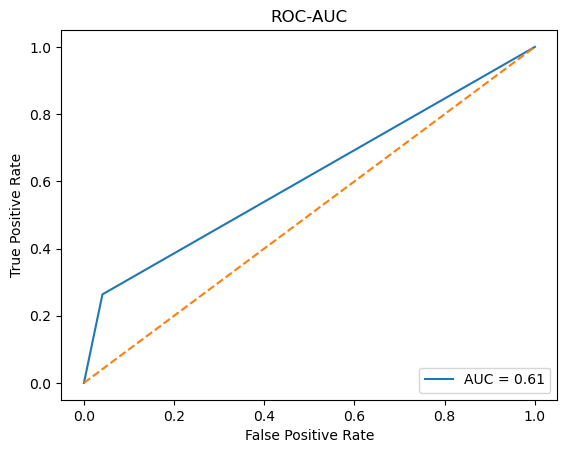

In [11]:
fpr, tpr, c = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred)


roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)


roc_display.plot()
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC-AUC")

In [13]:
random_forest = RandomForestClassifier()

params = {"n_estimators" : range(10, 201, 10), "criterion" : ["gini", "entropy"], "max_features" : range(2, len(X.columns) // 2)}

grid_search_rf = GridSearchCV(random_forest, param_grid=params, scoring="roc_auc", cv=4)
grid_search_rf.fit(X_train, y_train)





GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': range(2, 4),
                         'n_estimators': range(10, 201, 10)},
             scoring='roc_auc')

In [32]:
best_random_forest = grid_search_rf.best_estimator_
grid_search_rf.best_params_

{'criterion': 'entropy', 'max_features': 2, 'n_estimators': 130}

              precision    recall  f1-score   support

           0       0.77      0.97      0.85       317
           1       0.77      0.28      0.41       129

    accuracy                           0.77       446
   macro avg       0.77      0.62      0.63       446
weighted avg       0.77      0.77      0.73       446



Text(0.5, 1.0, 'ROC-AUC')

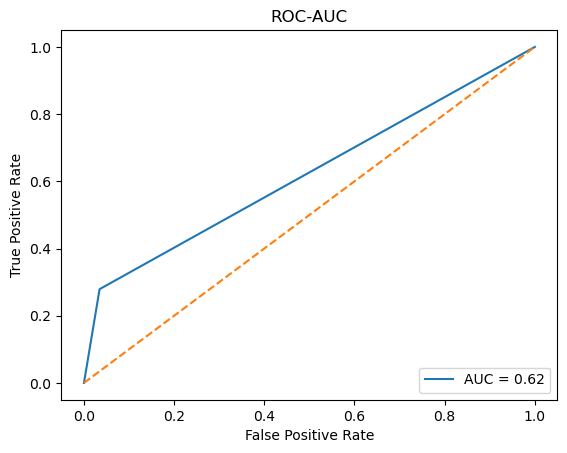

In [29]:
y_pred = best_random_forest.predict(X_test)

print(metrics.classification_report(y_test, y_pred))

fpr, tpr, c = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred)


roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)


roc_display.plot()
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC-AUC")

<Axes: title={'center': 'Топ важных признаков'}>

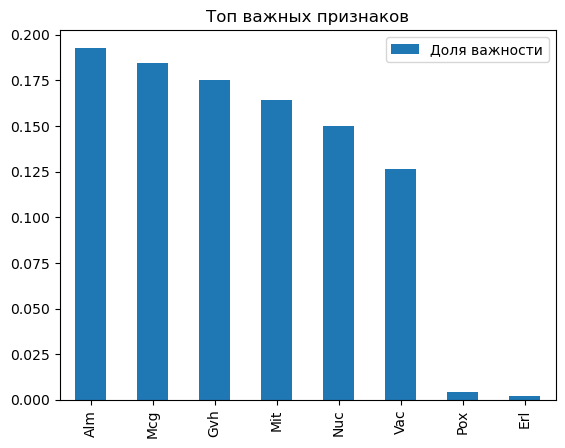

In [63]:
x = best_random_forest.feature_names_in_
y = best_random_forest.feature_importances_

pd.DataFrame(y, x, columns=["Доля важности"]).sort_values(by="Доля важности", ascending=False). \
                                            plot(kind="bar", title="Топ важных признаков")


Обучим SVM

In [22]:
krls = ["linear", "poly", "rbf", "sigmoid"]
gammas = ["scale", "auto"]
coef0s = [0, 1, 2, 5]
degrees = [2, 3, 4, 5]
Cs = [ 0.1, 1, 10, 20]

SVM = SVC()

params = {"kernel" : krls, "gamma" : gammas, "coef0" : coef0s, "degree" : degrees, "C" : Cs}

grid_search_svm = GridSearchCV(SVM, param_grid=params, scoring="roc_auc", cv=4)
grid_search_svm.fit(X_train, y_train)


GridSearchCV(cv=4, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 20], 'coef0': [0, 1, 2, 5],
                         'degree': [2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='roc_auc')

In [24]:
grid_search_svm.best_params_

{'C': 1, 'coef0': 5, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

              precision    recall  f1-score   support

           0       0.77      0.97      0.85       317
           1       0.77      0.28      0.41       129

    accuracy                           0.77       446
   macro avg       0.77      0.62      0.63       446
weighted avg       0.77      0.77      0.73       446

[[306  11]
 [ 93  36]]


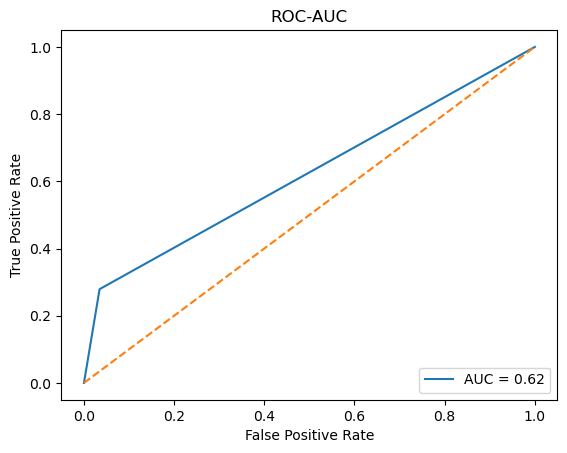

In [28]:
best_random_svm = grid_search_svm.best_estimator_
grid_search_svm.best_params_

y_pred = best_random_forest.predict(X_test)

print(metrics.classification_report(y_test, y_pred))

fpr, tpr, c = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred)


roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)


roc_display.plot()
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC-AUC")

print(metrics.confusion_matrix(y_test, y_pred))

Т.о. лучшая модель Random Forest